### 

## PIMA Indian Diabetes : Binary Prediction using Sinlge Layer Perceptron

![Alt text](RP_Docs/image-1.png)

#### Data Acquisition

For the below code, we load data from Kaggle 
<br>
<br>Kaggle, Pima indians diabetes database, Viewed 12 September 2023,  \<https://www.kaggle.com/uciml/pima-indians-diabetes-database\>

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

pima = pd.read_csv("RP_Docs/diabetes.csv")

#### Data Type for each Column(Attribute)

In [3]:
pima.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


We can see that all the attribute are of correct data type and does not warrant any type conversions

#### Histogram Representation for each attribute

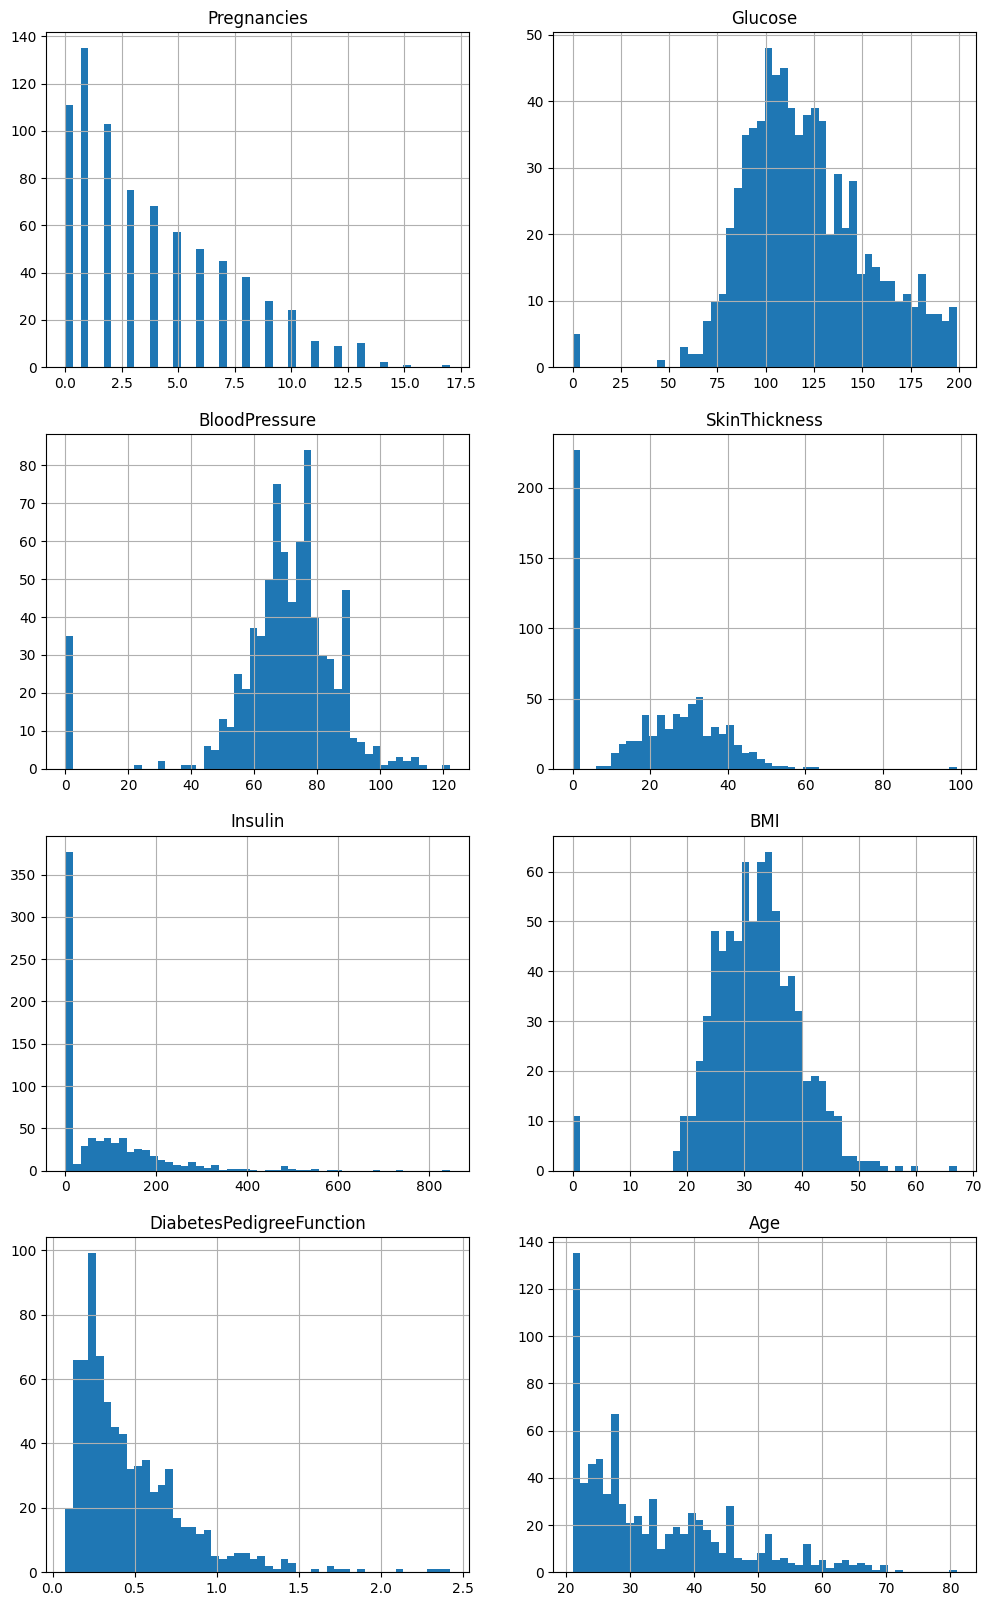

In [5]:
fig, axs = plt.subplots(4, 2, figsize=(12, 20))

for i in range(4):
    for j in range(2):
        col = i * 2 + j
        axs[i, j].hist(pima.iloc[:, col], bins=50)
        axs[i, j].set_title(pima.columns[col])
        axs[i, j].grid(True)

plt.show()

We can observe some left skewness in the data, there appear to be some 0 values which might suggest outliers but owing to context of dataset, removing them may result in loss of important information. So we rather process with standardization of the dataset

#### Attribute Description

In [6]:
pima.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


#### Missing Values

In [7]:
print(np.sum(pima.isna()))

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


There appear to be no missing values.

In [8]:
X = pima.drop('Outcome', axis=1)
y = pima['Outcome']

In [9]:
counts = y.value_counts()
print(counts)

0    500
1    268
Name: Outcome, dtype: int64


There appear to be imbalance in the outcome variable, but instead of balancing we proceed with evaluating the model in stratified  fold cross validation with shuffling, to ensure that this ratio remains

### Stratified K-Fold Cross Validation
#### Feature Scaling
All the input features are numerical values,<br> Standarization (Z-score normalization):

$$ x_i = \frac{(x_i−\mu_i)}{\sigma} $$
 
$ \mu = \text{Mean} $ <br>
$ \sigma = \text{Standard deviation} $

We use the above depicted flowchart for our code, and analyse based on different learning rates and different activation function and optimizer

![Alt text](RP_Docs/image-2.png)

In [13]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
import time
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D


def train_and_evaluate(X, y, learning_rate):
    """Trains and evaluates a model using 5-fold 
    cross-validation. Plots the loss and accuracy curves
    and the ROC curves for all folds.

    Parameters:
    X (array-like): 2D-array of input features.
    y (array-like): list of target features.
    learning_rate (float): learning rate for SGD.

    Returns:
    mean_accuracy (float): mean accuracy score across all folds.
    mean_auc (float): mean AUC score across all folds.
    mean_execution_time (float): mean execution time across all folds.
    """

    n_splits = 5  # Number of folds
    stratified_kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=524) # Use for stratified folds
    accuracy_scores = [] # List of accuracy scores for each fold
    auc_scores = []  # List of AUC scores for each fold
    execution_times = [] # List of execution times for each fold
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    colors = ['r', 'g', 'b', 'c', 'm'] # Colors for the plots
    lines = ['-', '--', '-.', ':'] # Line styles for the plots
    
    for i, (train_index, test_index) in enumerate(stratified_kfold.split(X, y)): 
        X_train, X_test = X.iloc[train_index], X.iloc[test_index] 
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Standardize the data
        sc = StandardScaler()
        X_train = sc.fit_transform(X_train)
        X_test = sc.transform(X_test)

        #Setting Model Parameters
        model = Sequential()
        model.add(Dense(1, input_dim=X_train.shape[1], activation='sigmoid'))
        opt_1 = keras.optimizers.SGD(learning_rate=learning_rate)
        model.compile(loss='binary_crossentropy', optimizer=opt_1, metrics=['accuracy'])  

        # Early stopping callback
        early_stop = EarlyStopping(monitor='val_loss', patience=5)
        start_time = time.time()
        # Model training
        history = model.fit(X_train, y_train, epochs=1000, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stop], verbose=0)
        end_time = time.time()

        # Model Validation
        y_pred = model.predict(X_test)

        #Evaluation Metrics
        fpr, tpr, thresholds = roc_curve(y_test, y_pred)
        auc_score = roc_auc_score(y_test, y_pred)
        accuracy, acc_score = model.evaluate(X_test, y_test)
        accuracy_scores.append(acc_score)
        auc_scores.append(auc_score)
        execution_times.append(end_time - start_time)

        # Plot the loss and accuracy curves
        ax1.plot(history.history['loss'], linestyle=lines[0], color=colors[i])
        ax1.plot(history.history['val_loss'], linestyle=lines[1], color=colors[i])
        ax1.plot(history.history['accuracy'],  linestyle=lines[2], color=colors[i])
        ax1.plot(history.history['val_accuracy'], linestyle=lines[3], color=colors[i])

        ax2.plot(fpr, tpr, linestyle='-', color=colors[i])
        
    # Set the titles and labels for the subplots
    pa1 = Patch(facecolor=colors[0], edgecolor='black', label = "Fold 1")
    pa2 = Patch(facecolor=colors[1], edgecolor='black', label = "Fold 2")
    pa3 = Patch(facecolor=colors[2], edgecolor='black', label = "Fold 3")
    pa4 = Patch(facecolor=colors[3], edgecolor='black', label = "Fold 4")
    pa5 = Patch(facecolor=colors[4], edgecolor='black', label = "Fold 5")
    ax1.set_title('Loss and Accuracy Curves')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss / Accuracy')
    custom_lines = [Line2D([0], [0], linestyle='-', color='black'),
                Line2D([0], [0], linestyle='--', color='black'),
                Line2D([0], [0], linestyle='-.', color='black'),
                Line2D([0], [0], linestyle=':', color='black')]

    ax1.legend(custom_lines, ['Training Loss', 'Validation Loss', 'Training Accuracy', 'Validation Accuracy'], bbox_to_anchor=(0, 1.10, 1, 0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=2)
    ax2.set_title('ROC Curves')
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.legend(handles = [pa1, pa2, pa3, pa4, pa5], bbox_to_anchor=(0, 1.10, 1, 0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=3)
    mean_accuracy = np.mean(accuracy_scores)
    std_accuracy = np.std(accuracy_scores)
    mean_auc = np.mean(auc_scores)
    std_auc = np.std(auc_scores)
    mean_execution_time = np.mean(execution_times)
    std_execution_time = np.std(execution_times)
    mean_accuracy_ = mean_accuracy + std_accuracy
    # Print the results
    print(f"Mean Accuracy: {mean_accuracy:0.3f} +/- {std_accuracy:0.3f}")
    print(f"Mean Execution Time: {mean_execution_time:.3f} +/- {std_execution_time:.3f} seconds")
    print(f"Mean AUC: {mean_auc:0.3f} +/- {std_auc:0.3f}")
    
    return mean_accuracy_, mean_auc, mean_execution_time

### Activation Function: Sigmoid
### Optimizer: Stochastic Gradient Descent
### Loss Function: Binary Cross-Entropy

5/5 [==============================] - 0s 3ms/step - loss: 0.4221 - accuracy: 0.8105
Mean Accuracy: 0.768 +/- 0.029
Mean Execution Time: 85.619 +/- 8.401 seconds
Mean AUC: 0.821 +/- 0.049
5/5 [==============================] - 0s 3ms/step - loss: 0.4053 - accuracy: 0.8301
Mean Accuracy: 0.764 +/- 0.037
Mean Execution Time: 69.096 +/- 5.859 seconds
Mean AUC: 0.823 +/- 0.042
5/5 [==============================] - 0s 3ms/step - loss: 0.3997 - accuracy: 0.8235
Mean Accuracy: 0.763 +/- 0.043
Mean Execution Time: 14.675 +/- 4.217 seconds
Mean AUC: 0.826 +/- 0.041
5/5 [==============================] - 0s 2ms/step - loss: 0.3996 - accuracy: 0.8235
Mean Accuracy: 0.758 +/- 0.044
Mean Execution Time: 10.101 +/- 2.294 seconds
Mean AUC: 0.824 +/- 0.044
5/5 [==============================] - 0s 2ms/step - loss: 0.3975 - accuracy: 0.8170
Mean Accuracy: 0.762 +/- 0.033
Mean Execution Time: 1.867 +/- 0.576 seconds
Mean AUC: 0.832 +/- 0.038
5/5 [==============================] - 0s 2ms/step - loss: 0.

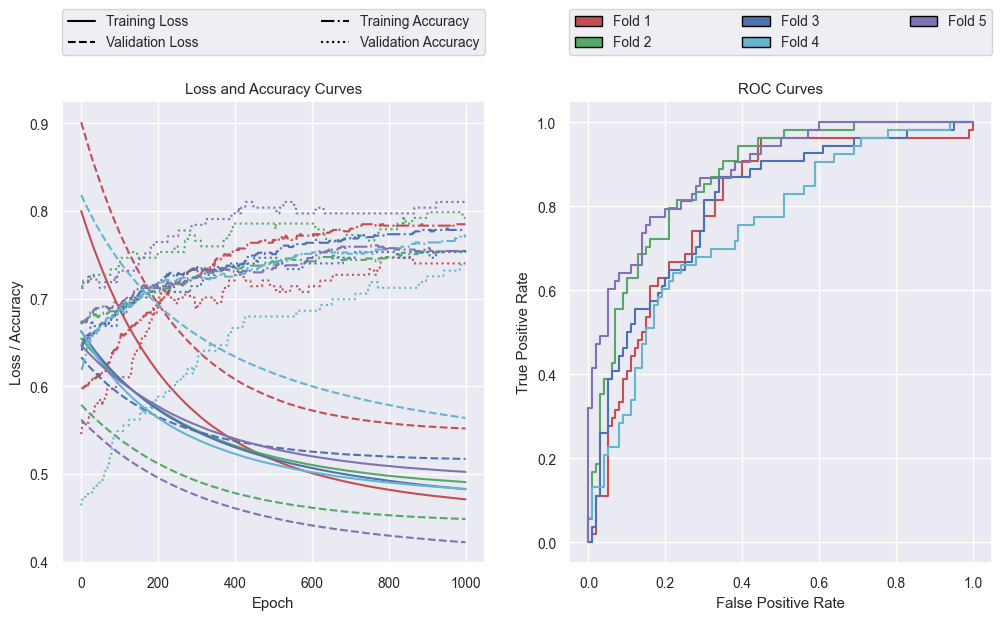

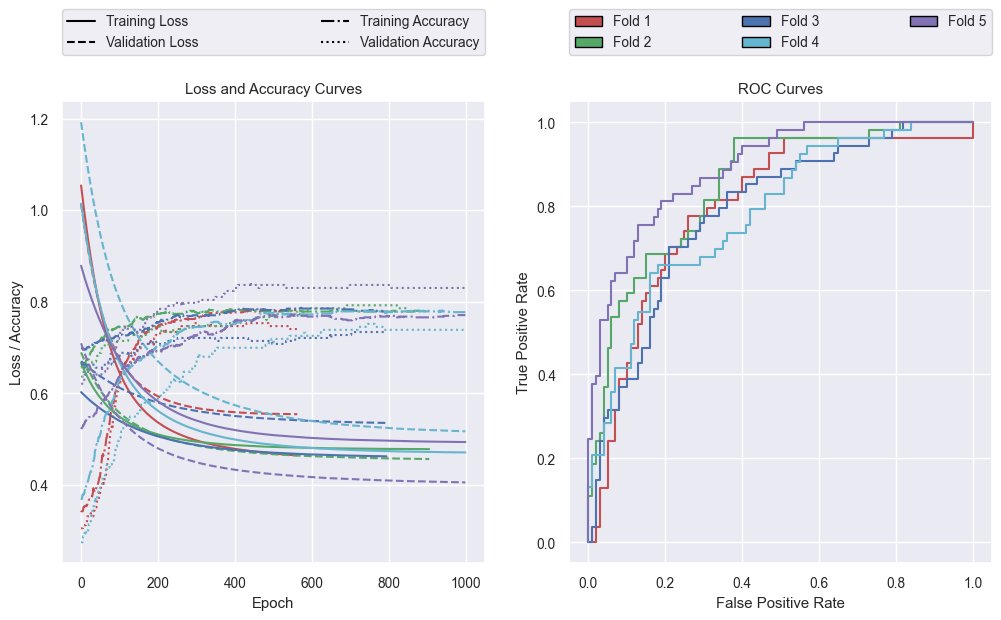

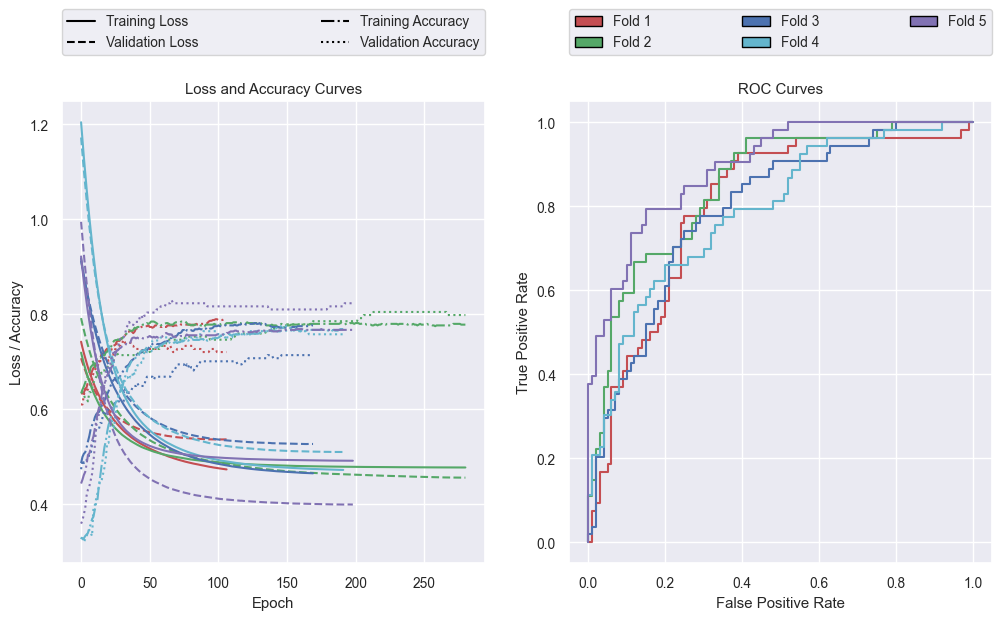

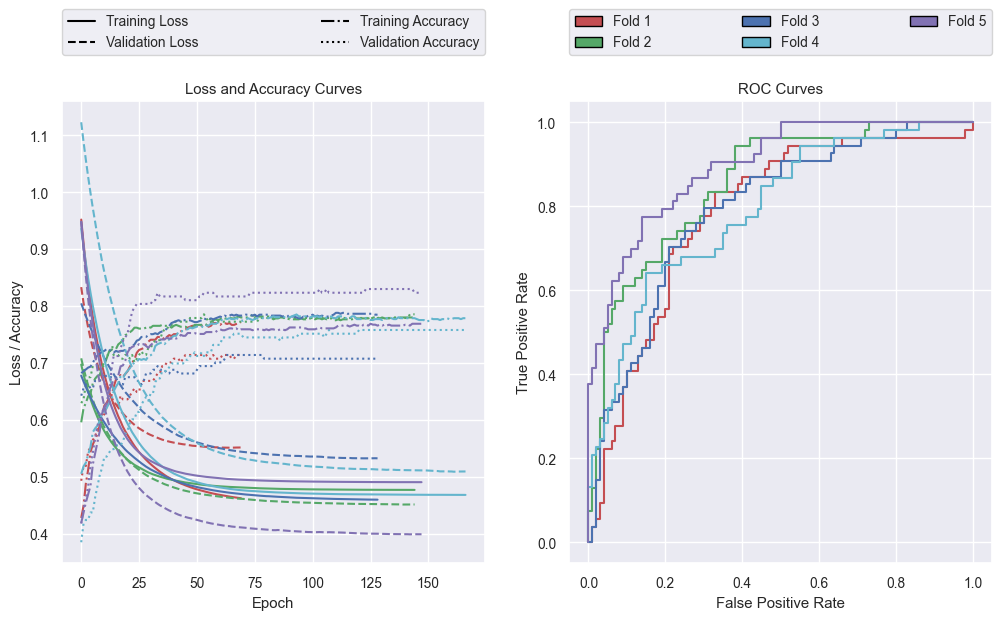

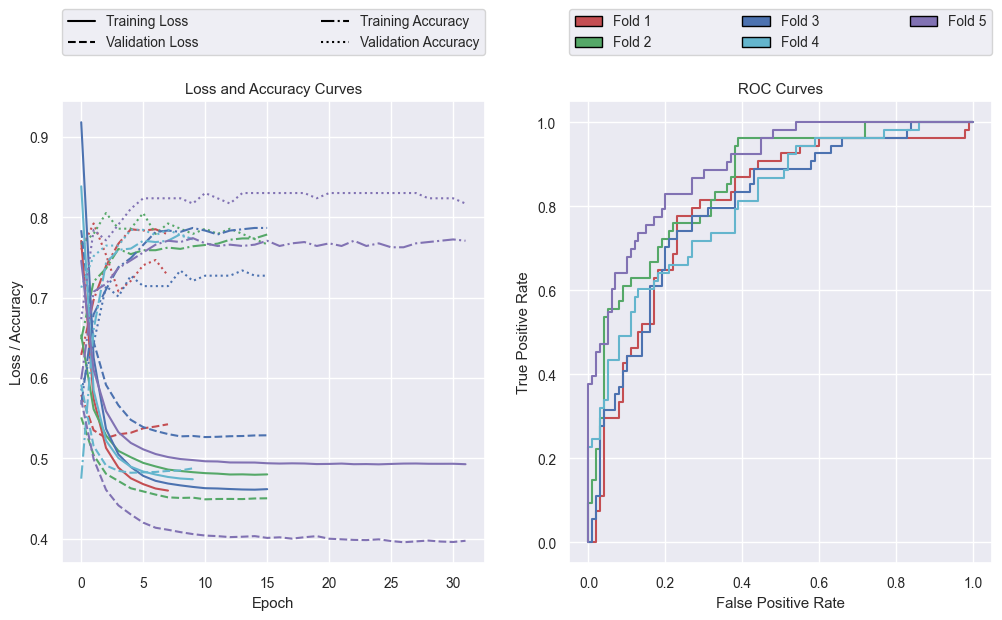

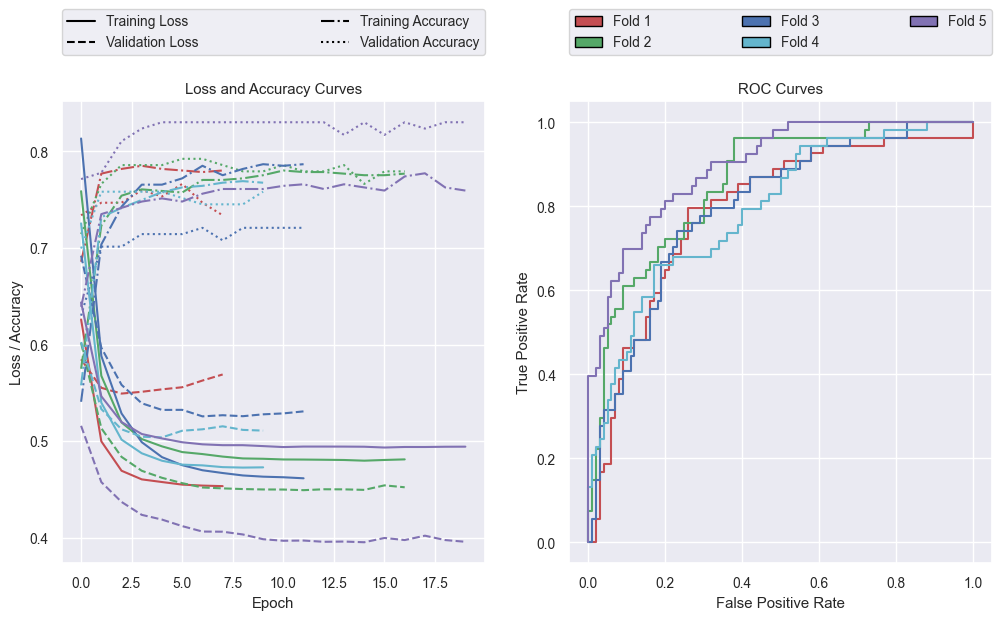

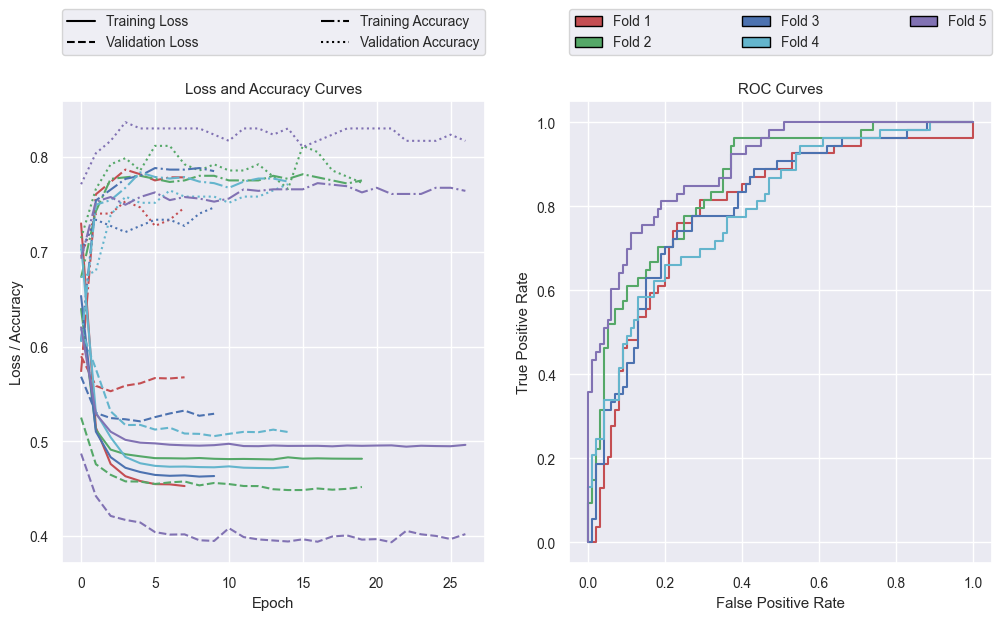

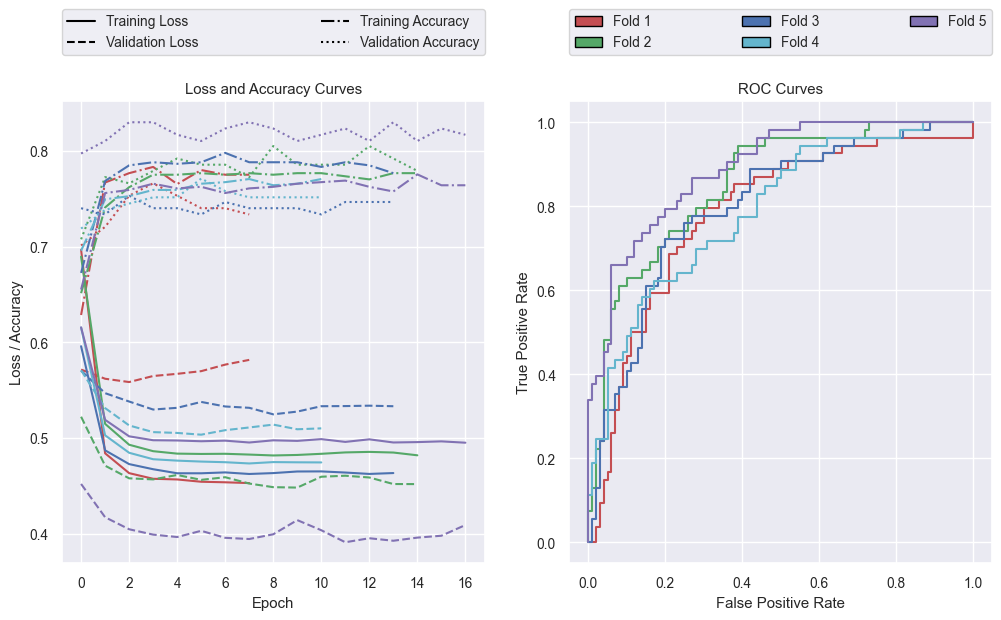

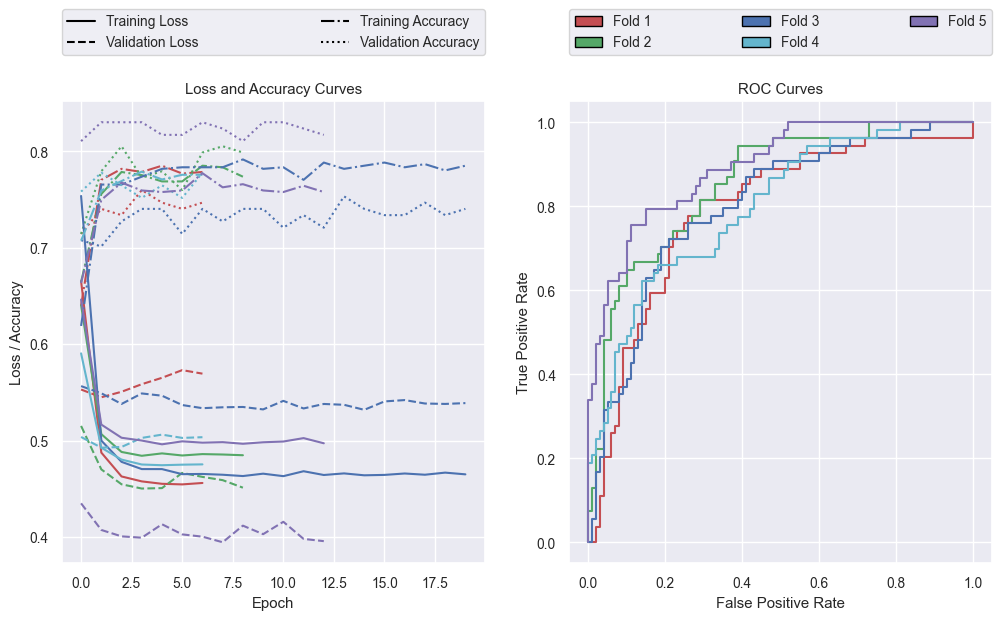

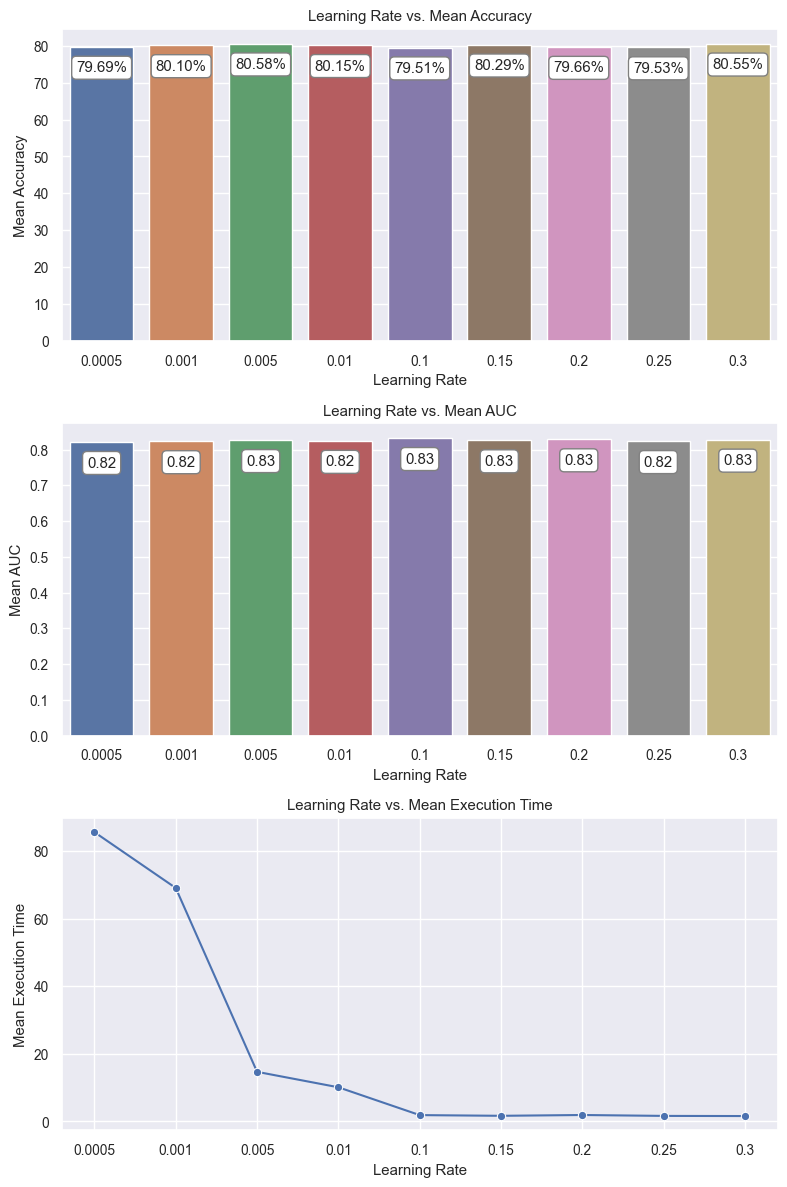

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale=0.9)

learning_rates = [0.0005, 0.001, 0.005, 0.01, 0.1, 0.15, 0.2, 0.25, 0.3] # List of learning rates to try

results = {'learning_rate': [], 'mean_accuracy': [], 'mean_auc': [], 'mean_execution_time': []}
for j in learning_rates:
    mean_accuracy, mean_auc, mean_execution_time = train_and_evaluate(X, y, learning_rate=j)
    results['learning_rate'].append(str(j))
    results['mean_accuracy'].append((mean_accuracy*100))
    results['mean_auc'].append(mean_auc)
    results['mean_execution_time'].append(mean_execution_time)

fig, axs = plt.subplots(3, 1, figsize=(8, 12))

# 1st plot: Line plot for learning rate vs. mean accuracy
sns.barplot(x='learning_rate', y='mean_accuracy', data=results, ax=axs[0])
axs[0].set_xlabel('Learning Rate')
axs[0].set_ylabel('Mean Accuracy')
axs[0].set_title('Learning Rate vs. Mean Accuracy')
for q in axs[0].patches:
    axs[0].annotate(format(q.get_height(), '.2f') + '%', 
                     (q.get_x() + q.get_width() / 2., q.get_height()), 
                     ha = 'center', va = 'center', 
                     xytext = (0, -15), 
                     textcoords = 'offset points',
                     bbox=dict(boxstyle='round', facecolor='white', edgecolor='gray', linewidth=1))

# 2nd plot: Line plot for learning rate vs. mean AUC
sns.barplot(x='learning_rate', y='mean_auc', data=results, ax=axs[1])
axs[1].set_xlabel('Learning Rate')
axs[1].set_ylabel('Mean AUC')
axs[1].set_title('Learning Rate vs. Mean AUC')
for q in axs[1].patches:
    axs[1].annotate(format(q.get_height(), '.2f'), 
                     (q.get_x() + q.get_width() / 2., q.get_height()), 
                     ha = 'center', va = 'center', 
                     xytext = (0, -15), 
                     textcoords = 'offset points',
                     bbox=dict(boxstyle='round', facecolor='white', edgecolor='gray', linewidth=1))

# 3rd plot: Line plot for learning rate vs. mean execution time
sns.lineplot(x='learning_rate', y='mean_execution_time', data=results, marker='o', ax=axs[2])
axs[2].set_xlabel('Learning Rate')
axs[2].set_ylabel('Mean Execution Time')
axs[2].set_title('Learning Rate vs. Mean Execution Time')

plt.tight_layout()
plt.show()